<a href="https://colab.research.google.com/github/santolina/Convolutional-Neural-Networks-in-TensorFlow/blob/master/Course_4_S%2BP_Week_2_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tf-nightly-2.0-preview
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 39kB/s 
     |████████████████████████████████| 3.8MB 35.9MB/s 
     |████████████████████████████████| 450kB 45.3MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


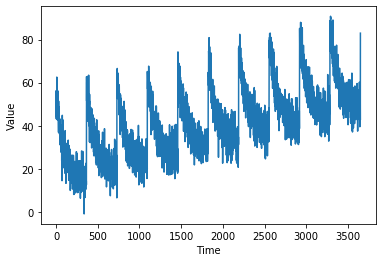

In [11]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10 # YOUR CODE HERE #
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01 # YOUR CODE HERE#
noise_level = 5 # YOUR CODE HERE#

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

Desired output -- a chart that looks like this:

![Chart showing upward trend and seasonailty](http://www.laurencemoroney.com/wp-content/uploads/2019/07/plot1.png)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [24]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)  )
model.fit(dataset,epochs=100,verbose=1)



Epoch 1/100
94/94 [==============================] - 1s 11ms/step - loss: 61.9570
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 42.3492
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 40.8500
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 39.5546
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 38.5928
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 38.6887
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 38.6396
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 37.3417
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 37.1310
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 37.6355
Epoch 11/100
94/94 [==============================] - 1s 5ms/step - loss: 37.2119
Epoch 12/100
94/94 [==============================] - 0s 5ms/step - loss: 37.2635
Epoch 13/100
94/94 [====

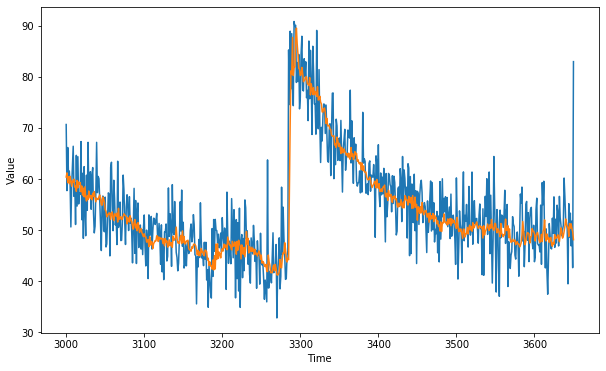

In [25]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

4.3798122